In [1]:
import sys
import os
import pickle

# Add the parent directory to sys.path
sys.path.append("/home/jovyan/video-storage/amit_files")

!pip install gym

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

from keypoints.keypoints.data_augments import TpsAndRotate, nop
from keypoints.keypoints.models import keynet
from keypoints.keypoints.utils import ResultsLogger
from keypoints.keypoints.ds import datasets as ds
from keypoints.keypoints.config import config

from keypoints.keypoints.ds.datasets import split

import yaml
from PIL import Image
import argparse
from pathlib import Path
import torch
import json
import numpy as np
from tqdm import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for gym_notices>=0.0.4 from https://files.pythonhosted.org/packages/25/26/d786c6bec30fe6110fd3d22c9a273a2a0e56c0b73b93e25ea1af5a53243b/gym_notices-0.0.8-py3-none-any.whl.metadata
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827731 sha256=a6743812beae36c6b4d1065a94c5c0763d746f100011aae25bf8f048fd4f269a
  Stored in directory: /home/jovyan/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym


2025-04-25 09:42:13.609656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 09:42:14.785328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
args_path = '/home/jovyan/video-storage/amit_files/Master_Thesis_Project/keypoints_KTH.yml'

torch.cuda.set_device(0)

args = config(['--config', args_path,'--data_root','/home/jovyan/video-storage/amit_files/Master_Thesis_Project/KTH_Dataset_2/paired_images'])
print(args)



Namespace(device=device(type='cuda', index=0), run_id=90, comment=None, demo=False, load=None, transfer_load=None, checkpoint_freq=1000, data_root='/home/jovyan/video-storage/amit_files/Master_Thesis_Project/KTH_Dataset_2/paired_images', config='/home/jovyan/video-storage/amit_files/Master_Thesis_Project/keypoints_KTH.yml', epochs=24, processes=7, seed=None, cma_algo=None, cma_step_mode='auto', cma_step_decay=0.001, cma_initial_step_size=None, cma_samples=None, cma_oversample=0, display=False, display_freq=5000, display_kp_rows=4, opt_level='O2', model_type='F', model_in_channels=3, model_keypoints=10, transporter_combine_mode='max', policy_action_select_mode='argmax', policy_depth=1, gym_reward_count_limit=None, optimizer='Adam', batch_size=16, lr=None, dataset=None, dataset_train_len=34000, dataset_test_len=274, dataset_randomize=False, data_aug_tps_cntl_pts=4, data_aug_tps_variance=0.05, data_aug_max_rotate=0.1, data_aug_type=None, dataset_1='first_images', dataset_2='second_images'

In [3]:
run_dir = f'data/models/keypoints/{args.model_type}/run_{args.run_id}'
run_dir

display = ResultsLogger(run_dir=run_dir,
                            num_keypoints=args.model_keypoints,
                            title = 'Results',
                            visuals = args.display,
                            image_capture_freq = args.display_freq,
                            kp_rows = args.display_kp_rows,
                            comment = args.comment)
display.header(args)


device: cuda:0 run_id: 90 comment: None demo: False load: None transfer_load: None checkpoint_freq: 1000 data_root: /home/jovyan/video-storage/amit_files/Master_Thesis_Project/KTH_Dataset_2/paired_images config: /home/jovyan/video-storage/amit_files/Master_Thesis_Project/keypoints_KTH.yml epochs: 24 processes: 7 seed: None cma_algo: None cma_step_mode: auto cma_step_decay: 0.001 cma_initial_step_size: None cma_samples: None cma_oversample: 0 display: False display_freq: 5000 display_kp_rows: 4 opt_level: O2 model_type: F model_in_channels: 3 model_keypoints: 10 transporter_combine_mode: max policy_action_select_mode: argmax policy_depth: 1 gym_reward_count_limit: None optimizer: Adam batch_size: 16 lr: None dataset: None dataset_train_len: 34000 dataset_test_len: 274 dataset_randomize: False data_aug_tps_cntl_pts: 4 data_aug_tps_variance: 0.05 data_aug_max_rotate: 0.1 data_aug_type: None dataset_1: first_images dataset_2: second_images model_z_channels: 64 cma_algo;: fast 


In [4]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch

class KthDataset(Dataset):
    def __init__(self, dir1, dir2, model=None, transform=None, shuffle=False):
        self.dir1 = os.path.join(args.data_root, args.dataset_1)
        self.dir2 = os.path.join(args.data_root, args.dataset_2)
        self.transform = transform
        self.model = model
        
        # Get image lists
        self.images1 = sorted(os.listdir(self.dir1))
        self.images2 = sorted(os.listdir(self.dir2))
        
        assert len(self.images1) == len(self.images2), "Both directories must contain the same number of images."
        
        # Create pairs of image paths
        self.image_pairs = list(zip(self.images1, self.images2))
        
        # Shuffle the pairs if requested
        if shuffle:
            random.shuffle(self.image_pairs)
            self.images1, self.images2 = zip(*self.image_pairs)

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.dir1, self.images1[idx])
        img2_path = os.path.join(self.dir2, self.images2[idx])
        
        # Open images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        # Apply any transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # Convert grayscale to 3-channel by stacking
        if img1.shape[0] == 1:  # If single channel
            img1 = torch.cat([img1, img1, img1], dim=0)  # Stack channel 3 times
        
        if img2.shape[0] == 1:  # If single channel
            img2 = torch.cat([img2, img2, img2], dim=0)  # Stack channel 3 times
        
        return img1, img2

def split(dataset, train_len, test_len):
    """
    Split a dataset into training and testing subsets.
    """
    assert train_len + test_len <= len(dataset), "Sum of train and test lengths exceeds dataset size"
    
    train_dataset, test_dataset = random_split(
        dataset, 
        [train_len, test_len],
        generator=torch.Generator().manual_seed(42)
    )
    
    return train_dataset, test_dataset


In [5]:
pin_memory = False if args.device == 'cpu' else True

# Define your transformation
Kth_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((img.size[0], img.size[1]), resample=Image.LANCZOS)),
    transforms.ToTensor(),
])

# Create the dataset with shuffling
dataset = KthDataset(
    args.dataset_1, 
    args.dataset_2, 
    model=None, 
    transform = Kth_transform,
    shuffle=True  # Enable shuffling at dataset creation
)

# Split into train and test
train_dataset, test_dataset = split(dataset, args.dataset_train_len, args.dataset_test_len)

In [6]:

# Create DataLoaders with additional shuffling
train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,  # Shuffle again during training
    drop_last=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,  # No need to shuffle test data
    drop_last=True,
    pin_memory=True
)

In [7]:

""" model """
kp_network = keynet.make(args).to(args.device)

print(kp_network)

optim = Adam(kp_network.parameters(), lr=1e-4)

""" data augmentation """
if args.data_aug_type == 'tps_and_rotate':
    augment = TpsAndRotate(args.data_aug_tps_cntl_pts, args.data_aug_tps_variance, args.data_aug_max_rotate)
else:
    augment = nop

import matplotlib.pyplot as plt
scaler = GradScaler()
threshold = 0.5

# criterion = PerceptualLoss()

def to_device(data, device):
    return tuple([x.to(device) for x in data])

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [8]:
# import torch
# import torch.nn as nn

# # Now you can use nn
# kp_network.decoder.out_block = nn.Sequential(
#     nn.Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1)),
#     nn.Sigmoid()  # Replace LeakyReLU with Sigmoid
# )

# kp_network = kp_network.to(args.device)
# kp_network

In [9]:
# !pip install piq

In [10]:
# from typing import Tuple, Union, List

# import torch
# import torch.nn.functional as F
# from torch.nn.modules.loss import _Loss

# from piq.utils import _validate_input, _reduce
# from piq.functional import gaussian_filter

# def _ssim_per_channel(x: torch.Tensor, y: torch.Tensor, kernel: torch.Tensor,
#                       data_range: Union[float, int] = 1., k1: float = 0.01,
#                       k2: float = 0.03) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
#     if x.size(-1) < kernel.size(-1) or x.size(-2) < kernel.size(-2):
#         raise ValueError(f'Kernel size can\'t be greater than actual input size. '
#                          f'Input size: {x.size()}. Kernel size: {kernel.size()}')

#     c1 = k1 ** 2
#     c2 = k2 ** 2
#     n_channels = x.size(1)
#     mu_x = F.conv2d(x, weight=kernel, stride=1, padding=0, groups=n_channels)
#     mu_y = F.conv2d(y, weight=kernel, stride=1, padding=0, groups=n_channels)

#     mu_xx = mu_x ** 2
#     mu_yy = mu_y ** 2
#     mu_xy = mu_x * mu_y

#     sigma_xx = F.conv2d(x ** 2, weight=kernel, stride=1, padding=0, groups=n_channels) - mu_xx
#     sigma_yy = F.conv2d(y ** 2, weight=kernel, stride=1, padding=0, groups=n_channels) - mu_yy
#     sigma_xy = F.conv2d(x * y, weight=kernel, stride=1, padding=0, groups=n_channels) - mu_xy

#     # Contrast sensitivity (CS) with alpha = beta = gamma = 1.
#     cs = (2. * sigma_xy + c2) / (sigma_xx + sigma_yy + c2)

#     # Structural similarity (SSIM)
#     ss = (2. * mu_xy + c1) / (mu_xx + mu_yy + c1) * cs

#     ssim_val = ss.mean(dim=(-1, -2))
#     cs = cs.mean(dim=(-1, -2))
#     return ssim_val, cs


# def ssim(x: torch.Tensor, y: torch.Tensor, kernel_size: int = 11, kernel_sigma: float = 1.5,
#          data_range: Union[int, float] = 1., reduction: str = 'mean', full: bool = False,
#          downsample: bool = False, k1: float = 0.01, k2: float = 0.03) -> List[torch.Tensor]:
    
#     assert kernel_size % 2 == 1, f'Kernel size must be odd, got [{kernel_size}]'
#     _validate_input([x, y], dim_range=(4, 5), data_range=(0, data_range))

#     x = x / float(data_range)
#     y = y / float(data_range)

#     # Averagepool image if the size is large enough
#     f = max(1, round(min(x.size()[-2:]) / 256))
#     if (f > 1) and downsample:
#         x = F.avg_pool2d(x, kernel_size=f)
#         y = F.avg_pool2d(y, kernel_size=f)

#     kernel = gaussian_filter(kernel_size, kernel_sigma, device=x.device, dtype=x.dtype).repeat(x.size(1), 1, 1, 1)
#     _compute_ssim_per_channel = _ssim_per_channel_complex if x.dim() == 5 else _ssim_per_channel
#     ssim_map, cs_map = _compute_ssim_per_channel(x=x, y=y, kernel=kernel, data_range=data_range, k1=k1, k2=k2)
#     ssim_val = ssim_map.mean(1)
#     cs = cs_map.mean(1)

#     ssim_val = _reduce(ssim_val, reduction)
#     cs = _reduce(cs, reduction)

#     if full:
#         return [ssim_val, cs]

#     return ssim_val


# class SSIMLoss(_Loss):
    
#     __constants__ = ['kernel_size', 'k1', 'k2', 'sigma', 'kernel', 'reduction']

#     def __init__(self, kernel_size: int = 11, kernel_sigma: float = 1.5, k1: float = 0.01, k2: float = 0.03,
#                  downsample: bool = False, reduction: str = 'mean', data_range: Union[int, float] = 1.) -> None:
#         super().__init__()

#         # Generic loss parameters.
#         self.reduction = reduction

#         # Loss-specific parameters.
#         self.kernel_size = kernel_size

#         # This check might look redundant because kernel size is checked within the ssim function anyway.
#         # However, this check allows to fail fast when the loss is being initialised and training has not been started.
#         assert kernel_size % 2 == 1, f'Kernel size must be odd, got [{kernel_size}]'
#         self.kernel_sigma = kernel_sigma
#         self.k1 = k1
#         self.k2 = k2
#         self.downsample = downsample
#         self.data_range = data_range

#     def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:

#         score = ssim(x=x, y=y, kernel_size=self.kernel_size, kernel_sigma=self.kernel_sigma, downsample=self.downsample,
#                      data_range=self.data_range, reduction=self.reduction, full=False, k1=self.k1, k2=self.k2)
#         return torch.ones_like(score) - score

In [11]:
import torch
import torch.nn.functional as F

class SSIMLoss(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = self.create_window(window_size, self.channel)

    def gaussian(self, window_size, sigma):
        """
        Generate a 1D Gaussian kernel
        """
        gauss = torch.Tensor([
            torch.exp(-(x - window_size//2)**2/float(2*sigma**2)) 
            for x in range(window_size)
        ])
        return gauss/gauss.sum()

    def create_window(self, window_size, channel):
        """
        Create a 2D Gaussian window
        """
        _1D_window = self.gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    def _ssim(self, img1, img2, window, window_size, channel, size_average=True):
        """
        Calculate SSIM
        """
        mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

        C1 = 0.01**2
        C2 = 0.03**2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        if size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)

    def forward(self, img1, img2):
        """
        Input:
            img1, img2: Images with shape [B, C, H, W]
        Returns:
            SSIM loss (1-SSIM)
        """
        # Ensure the window is on the same device as the input
        (_, channel, _, _) = img1.size()
        if channel == self.channel and self.window.device == img1.device:
            window = self.window
        else:
            self.channel = channel
            window = self.create_window(self.window_size, channel)
            window = window.to(img1.device)
            self.window = window
        
        # Calculate SSIM
        ssim_value = self._ssim(img1, img2, window, self.window_size, channel, self.size_average)
        
        # Return SSIM loss (1-SSIM)
        return 1 - ssim_value

# Usage example:
# ssim_loss = SSIMLoss()
# loss = ssim_loss(predicted_images, target_images)

In [12]:
criterion = SSIMLoss()

TypeError: exp(): argument 'input' (position 1) must be Tensor, not float

In [ ]:
# Initialize lists to store losses for each epoch
train_losses = []
val_losses = []

# Initialize the loss file before training
loss_file_path = run_dir + '/losses.json'
with open(loss_file_path, 'w') as f:
    json.dump({'train_losses': [], 'val_losses': []}, f)


In [ ]:
# Main training loop
for epoch in tqdm(range(0, args.epochs + 1)):
    epoch_train_loss = 0
    epoch_val_loss = 0
    num_train_batches = 0
    num_val_batches = 0

    if not args.demo:
        # Training
        batch = tqdm(train_loader, total=len(train_dataset) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_ = data[0].to(args.device), data[1].to(args.device)
            
            optim.zero_grad()

            # Mixed precision forward pass
            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x, x_)
                # loss = criterion(x_t, x_,loss_mask = None)
                loss = criterion(x_, x_t)
                epoch_train_loss += loss.item()
                num_train_batches += 1

            # Scaled backward pass
            scaler.scale(loss).backward()
            scaler.step(optim)    # Update model parameters
            scaler.update()       # Adjust the scale for next iteration

            if i % args.checkpoint_freq == 0:
                kp_network.save(run_dir + '/checkpoint')
                
            display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask=None, type='train', depth=20)

    # Calculate average train loss for the epoch
    epoch_train_loss /= max(1, num_train_batches)
    train_losses.append(epoch_train_loss)

    # Validation
    with torch.no_grad():
        batch = tqdm(test_loader, total=len(test_dataset) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_ = data[0].to(args.device), data[1].to(args.device)

            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x, x_)
                # loss = criterion(x_t, x_,loss_mask = None)
                loss = criterion(x_, x_t)
                epoch_val_loss += loss.item()
                num_val_batches += 1

            display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask=None, type='test', depth=20)

    # Calculate average validation loss for the epoch
    epoch_val_loss /= max(1, num_val_batches)
    val_losses.append(epoch_val_loss)

    # Save the updated train and val losses after each epoch
    with open(loss_file_path, 'r+') as f:
        loss_data = json.load(f)
        loss_data['train_losses'].append(epoch_train_loss)
        loss_data['val_losses'].append(epoch_val_loss)
        f.seek(0)  # Go to the beginning of the file
        json.dump(loss_data, f, indent=4)  # Write updated data
        f.truncate()  # Remove any leftover data from previous writes

    ave_loss, best_loss = display.end_epoch(epoch, optim)

    # Save if model improved
    if ave_loss <= best_loss and not args.demo:
        kp_network.save(run_dir + '/best')


In [14]:
kp_network.decoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/decoder/core.mdl'))
kp_network.decoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/decoder/in_block.mdl'))
kp_network.decoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/decoder/out_block.mdl'))

kp_network.encoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/encoder/core.mdl'))
kp_network.encoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/encoder/in_block.mdl'))
kp_network.encoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/encoder/out_block.mdl'))

kp_network.keypoint.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/keypoint/core.mdl'))
kp_network.keypoint.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/keypoint/in_block.mdl'))
kp_network.keypoint.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/best/keypoint/out_block.mdl'))

# 48

kp_network.eval()

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [15]:
loaded_data = np.load("/home/jovyan/video-storage/amit_files/Master_Thesis_Project/KTH_image_batches.npz", allow_pickle=True)
x_list_loaded = [torch.tensor(arr) for arr in loaded_data["x_list"]]
x_dash_list_loaded = [torch.tensor(arr) for arr in loaded_data["x_dash_list"]]

In [16]:
print(x_list_loaded[0].shape)
print(x_dash_list_loaded[0].shape)

torch.Size([16, 3, 120, 160])
torch.Size([16, 3, 120, 160])


In [17]:
for ind in tqdm(range(0, len(x_list_loaded))):
    with autocast():
        x = x_list_loaded[ind].to(device="cuda")
        x_ = x_dash_list_loaded[ind].to(device="cuda")
        x_t, z, k, m, p, heatmap = kp_network(x, x_)
        img = x_t.detach().cpu().numpy()
        print(np.unique(img))
        # break

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

[0.01634 0.0164  0.01646 ... 0.853   0.8535  0.854  ]


  0%|                                                                                   | 0/1 [00:00<?, ?it/s]

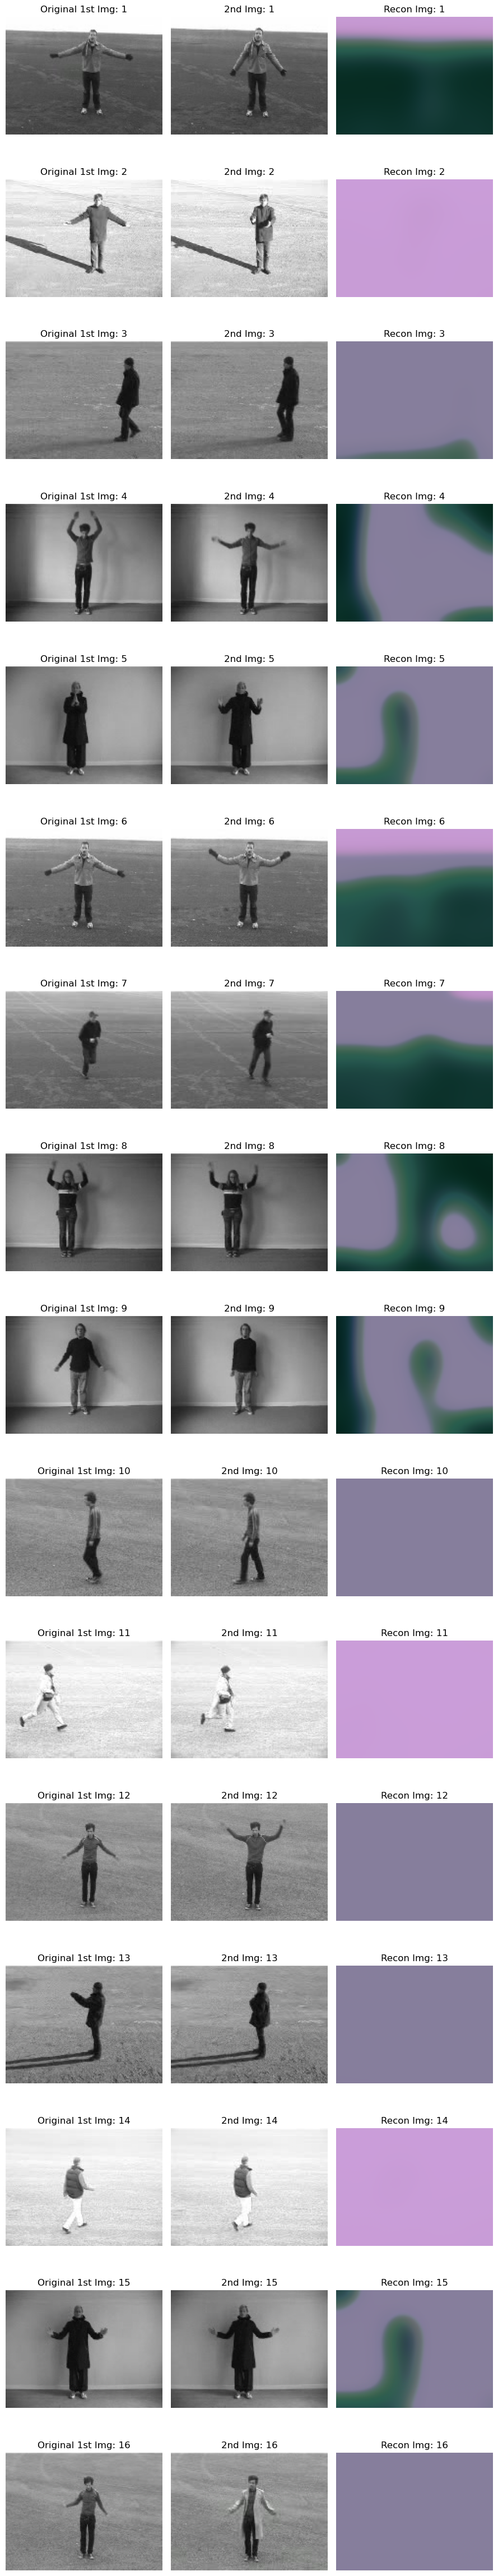

  0%|                                                                                   | 0/1 [00:03<?, ?it/s]


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast

def plot_corresponding_images(tensor1, tensor2, tensor3, k=None):
    tensor1 = tensor1.detach().cpu().numpy()
    tensor2 = tensor2.detach().cpu().numpy()
    tensor3 = tensor3.detach().cpu().numpy()

    batch_size = tensor1.shape[0]
    num_cols = 3
    num_rows = batch_size

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(batch_size):
        for j, tensor in enumerate([tensor1, tensor2, tensor3]):
            image = np.transpose(tensor[i], (1, 2, 0)).astype(np.float32)  # Ensure float32
            image = np.clip(image, 0, 1)

            ax = axes[i, j]
            ax.imshow(image)
            ax.axis("off")

            if j == 0:
                ax.set_title(f"Original 1st Img: {i+1}")
            elif j == 1:
                ax.set_title(f"2nd Img: {i+1}")
            else:
                ax.set_title(f"Recon Img: {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.97)
    plt.show()


# ---------- Run inference and plot ----------
for ind in tqdm(range(0, len(x_list_loaded))):
    with autocast():
        x = x_list_loaded[ind].to(device="cuda")
        x_ = x_dash_list_loaded[ind].to(device="cuda")
        x_t, z, k, m, p, heatmap = kp_network(x, x_)

    # Plot the result
    plot_corresponding_images(x, x_, x_t, k)
    break  # Remove this if you want to plot more batches


In [19]:
import json
import matplotlib.pyplot as plt

# Load the first JSON file (epochs 1 to 17)
with open("/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_83/losses.json", "r") as f:
    data = json.load(f)


# Extract train and validation losses
train_losses = data["train_losses"]
val_losses = data["val_losses"]

# Create epoch numbers (1-based index)
epochs = list(range(1, len(train_losses) + 1))


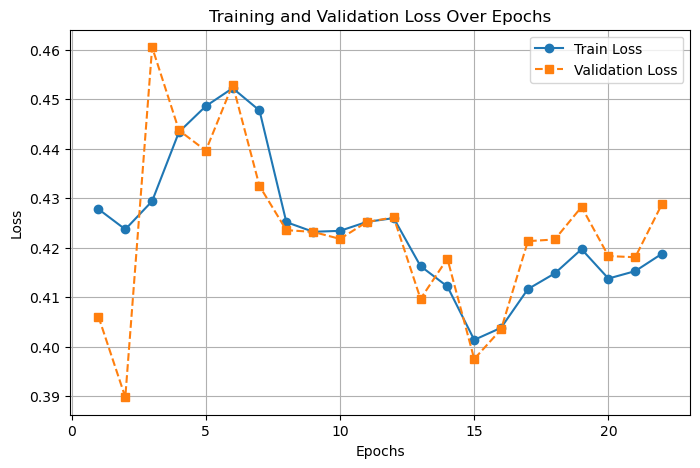

In [20]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
